In [1]:
try:
    import bed
except ImportError:
    %pip install bayesdesign

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('/home/ashandonay/bed/bayesdesign/src/bed/')
from grid import Grid
from design import ExperimentDesigner

# Subgrid Example

This notebook demonstrates how to utilize the subgrid capabilities of the ExperimentDesigner. It uses the same example that's featured in [LocationFinding.ipynb](LocationFinding.ipynb).

In [4]:
L = 10
designs = Grid(x_obs=np.linspace(0, L, 40), y_obs=np.linspace(0, L, 40))
features = Grid(s=np.linspace(np.log(0.08), np.log(1.5), 100))
params = Grid(l_x1=np.linspace(0, L, 75), l_y1=np.linspace(0, L, 75), b=0.1, m=1.0)

The grid approach to calculating the EIG requires a fully tabulated likelihood which depends on features, designs, and parameters. The likelihood object becomes incresingly large in memory for each added variable in any of these dimensions. As a result, there is some upper limit on how many axes and how many grid points can be utilized in calculating the EIG. 

However, since EIG is just a function of designs, it can be calculated just the same, but with subgrids of the full designs grid. Then the full EIG can be constructed from the output of calculating the EIG of the individual subgrids.

In [5]:
def calculate_likelihood(features, designs, params, **kwargs):
    sq_two_norm = np.square(designs.x_obs - params.l_x1) + np.square(designs.y_obs - params.l_y1)
    sq_two_norm_inverse = 1/(params.m + sq_two_norm)
    s_mean = np.log(params.b + sq_two_norm_inverse)
    s_diff = features.s - s_mean
    likelihood = np.exp(-0.5 * (s_diff / kwargs['sigma_s']) ** 2)
    return likelihood

The subgrids are utilized when a `mem` argument is specified in the initialization of `ExperimentDesigner`. `mem` is the maximum size in MB that you want to allow the likelihood to reach. If this value is too small to be achieved by the maximum amount of subgrids, an error will appear.

In [6]:
designer = ExperimentDesigner(
    params, 
    features, 
    designs, 
    calculate_likelihood, 
    lfunc_args={'sigma_s': 0.1},
    mem=1000
    )

If the input value of `mem` is high enough to allow for subgrids, but low enough to require subgrids, then the `calculateEIG` method will print how many subgrids are needed to calculate the full EIG array. In addition, the sub_likelihood shape and size will be displayed in the describe function below the shape and size of the full likelihood.

In [7]:
prior = np.ones(params.shape)
params.normalize(prior)

best = designer.calculateEIG(prior)
designer.describe()

Splitting design grid into 7 subgrids...
GRID           designs [40:x_obs, 40:y_obs]
GRID          features [100:s]
GRID        parameters [75:l_x1, 75:l_y1, 1:b, 1:m]
ARRAY            prior (75, 75, 1, 1)                   0.0 Mb
ARRAY  full_likelihood (100, 40, 40, 75, 75, 1, 1)    6866.5 Mb
ARRAY       likelihood (100, 233, 1, 75, 75, 1, 1)     999.9 Mb
ARRAY         marginal (100, 233, 1)                    0.2 Mb
ARRAY               IG (100, 233, 1)                    0.2 Mb
ARRAY              EIG (40, 40)                         0.0 Mb


`CalculateEIG` will take longer to run with subgrids since it's calculated over a loop. However, we gain the ability to calculate EIG over a larger grid of designs without the same memory constraints. The output EIG array matches the full designs grid result.

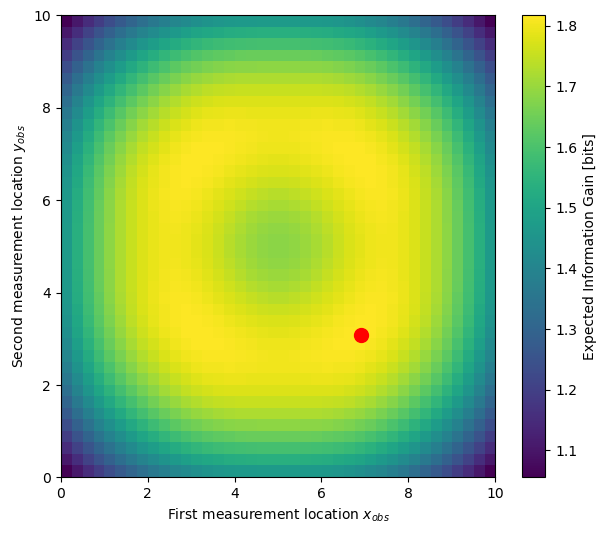

In [8]:
fig, ax = plt.subplots(figsize=(7,6))
I = ax.imshow(designer.EIG.T, origin='lower', extent=designs.extent('x_obs')+designs.extent('y_obs'), aspect='auto')
plt.colorbar(I, ax=ax, label='Expected Information Gain [bits]')
ax.plot(best['x_obs'], best['y_obs'], 'ro', markersize=10)
ax.set(xlabel='First measurement location $x_{obs}$', ylabel='Second measurement location $y_{obs}$');
plt.show()